# Transfer from walking to other tasks

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import ranksums
from bbbqd.body.body_utils import compute_body_encoding_function
import numpy as np
%matplotlib inline

In [5]:
# tasks = ["BridgeWalker-v0", "CustomPusher-v0", "CustomCarrier-v0", "UpStepper-v0", "DownStepper-v0",
#          "ObstacleTraverser-v0", "ObstacleTraverser-v1", "Hurdler-v0", "PlatformJumper-v0", "GapJumper-v0",
#          "CaveCrawler-v0"
#          ]
tasks = ["BridgeWalker-v0", "CustomCarrier-v0", "PlatformJumper-v0", "CaveCrawler-v0"
         ]

In [15]:
evo_dfs = []
sampling = "all"
for task in tasks:
    processed_task = task.replace("-v0", "").lower()
    for seed in range(10):
        try:
            tmp_df = pd.read_csv(f"../results/me/evo-body-10x10-{processed_task}-{sampling}_{seed}.csv")
            tmp_df["seed"] = seed
            tmp_df["task"] = task
            tmp_df["sampling"] = "evo_me"  # sampling
            tmp_df["repertoire"] = "all"
            evo_dfs.append(tmp_df)
        except FileNotFoundError:
            print(task, seed)

        tmp_df = pd.read_csv(f"../results/ga/evo-body-10x10-{processed_task}_{seed}.csv")
        tmp_df["seed"] = seed
        tmp_df["task"] = task
        tmp_df["sampling"] = "evo_ga"  # sampling
        tmp_df["repertoire"] = "all"
        evo_dfs.append(tmp_df)
evo_df = pd.concat(evo_dfs, ignore_index=True)
evo_df.head()

CaveCrawler-v0 9


,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,seed,task,sampling,repertoire
0,1.0,1.033856,-2.813630,2.786834,-7.729624,1.269531,5.957031,2.636719,23.280643,2024-06-04 19:39:47.713679,0.0,0,BridgeWalker-v0,evo_me,all
1,2.0,1.033856,-2.283975,8.642919,-10.980222,1.367188,7.714844,3.222656,13.593169,2024-06-04 19:40:01.307147,0.0,0,BridgeWalker-v0,evo_me,all
2,3.0,1.033856,1.529860,15.400932,-9.685629,1.464844,9.082031,3.320312,13.195543,2024-06-04 19:40:14.503131,0.0,0,BridgeWalker-v0,evo_me,all
3,4.0,1.033856,1.782396,20.309895,-9.502535,1.464844,9.863281,3.417969,13.382216,2024-06-04 19:40:27.885777,0.0,0,BridgeWalker-v0,evo_me,all
4,5.0,1.033856,4.763123,26.261871,-11.015659,1.464844,11.132812,3.808594,13.246979,2024-06-04 19:40:41.133130,0.0,0,BridgeWalker-v0,evo_me,all


## Processing time

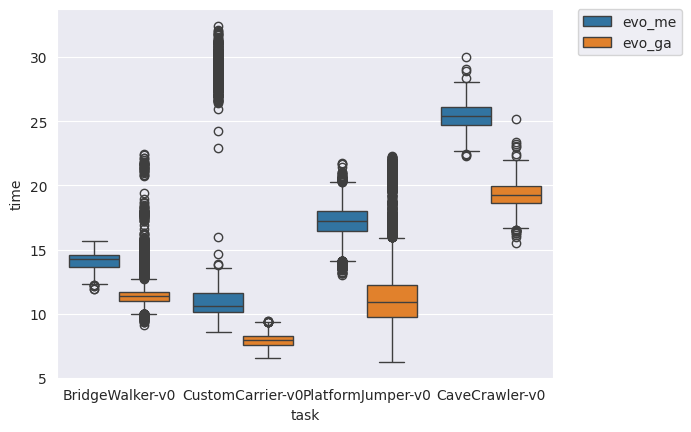

In [7]:
# sns.boxplot(
#     evo_df[evo_df["iteration"] > 5],
#     y="time",
#     hue="task",
# )
sns.boxplot(
    evo_df[evo_df["iteration"] > 5],
    x="task",
    y="time",
    hue="sampling",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Evolution results

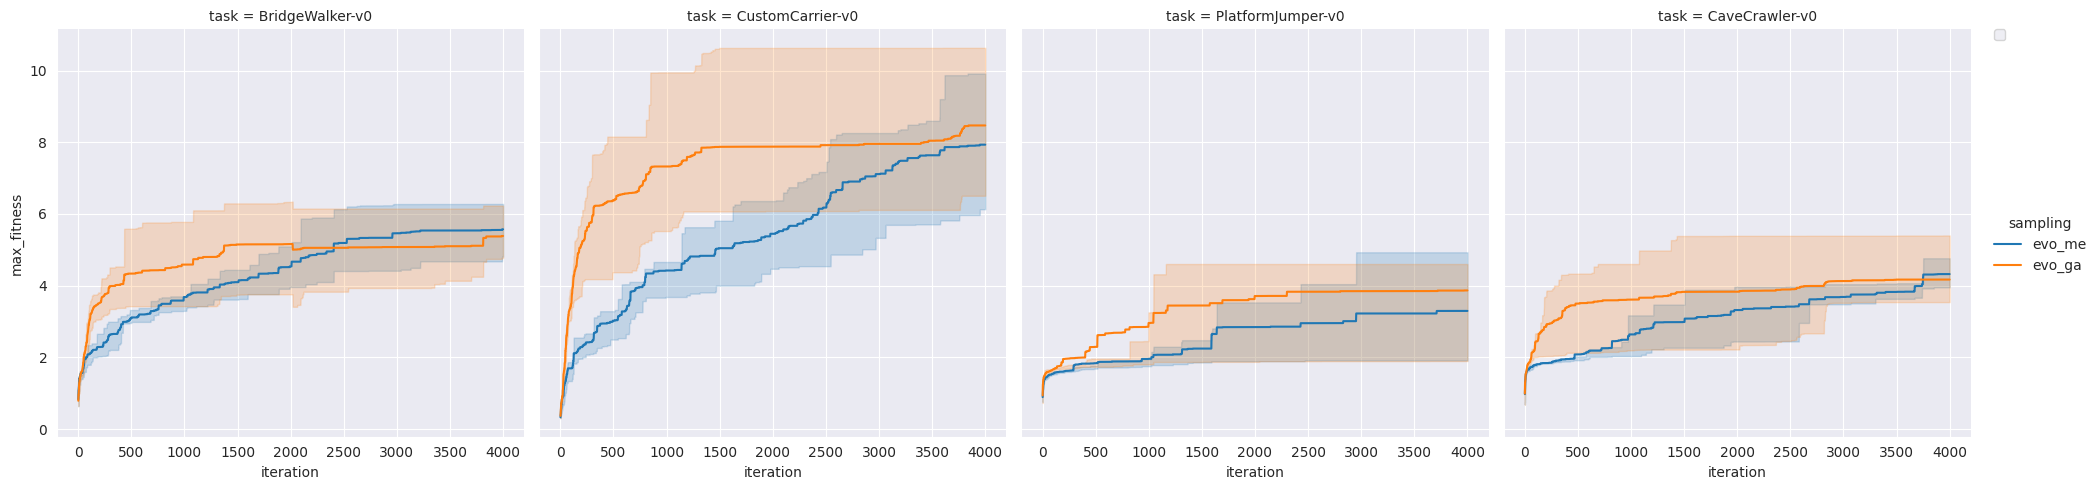

In [8]:
# sns.lineplot(
#     evo_df,
#     x="iteration",
#     y="max_fitness",
#     hue="task",
#     estimator="median",
#     errorbar=("pi", 50),
# )
sns.relplot(
    data=evo_df, x="iteration", y="max_fitness", col="task",
    hue="sampling", kind="line", errorbar=("pi", 50),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [9]:
final_evo_df = evo_df[evo_df["iteration"] == max(evo_df["iteration"])][
    ["max_fitness", "coverage1", "coverage2", "coverage3", "task", "seed", "sampling", "repertoire"]]
final_evo_df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.41797,37.988280,BridgeWalker-v0,0,evo_me,all
7999,6.584088,NaN,NaN,NaN,BridgeWalker-v0,0,evo_ga,all
11999,6.262626,16.699219,55.76172,42.871094,BridgeWalker-v0,1,evo_me,all
15999,5.954528,NaN,NaN,NaN,BridgeWalker-v0,1,evo_ga,all
19999,4.975401,21.875000,55.95703,44.433594,BridgeWalker-v0,2,evo_me,all


## Task transfer results

In [10]:
dfs = [final_evo_df]
samplings = ["all", "s1", "s2", "s3"]
repertoires = [f"g{i + 1}" for i in range(3)]
for task in tasks:
    for seed in range(10):
        tmp_df = pd.read_csv(f"../results/transfer/evo-body-10x10_{seed}_{task}.csv")
        tmp_df["seed"] = seed
        tmp_df["task"] = task
        tmp_df["sampling"] = "ga"
        tmp_df["repertoire"] = "all"
        tmp_df["max_fitness"] = tmp_df["max_fitness"].apply(lambda x: float(x.replace("[", "").replace("]", "")))
        dfs.append(tmp_df)

        for sampling in samplings:
            for rep in repertoires:
                tmp_df = pd.read_csv(f"../results/transfer/evo-body-10x10-floor-{sampling}_{seed}_{rep}_{task}.csv")
                tmp_df["seed"] = seed
                tmp_df["task"] = task
                tmp_df["sampling"] = sampling
                tmp_df["repertoire"] = rep
                dfs.append(tmp_df)
df = pd.concat(dfs)
df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.41797,37.988280,BridgeWalker-v0,0,evo_me,all
7999,6.584088,NaN,NaN,NaN,BridgeWalker-v0,0,evo_ga,all
11999,6.262626,16.699219,55.76172,42.871094,BridgeWalker-v0,1,evo_me,all
15999,5.954528,NaN,NaN,NaN,BridgeWalker-v0,1,evo_ga,all
19999,4.975401,21.875000,55.95703,44.433594,BridgeWalker-v0,2,evo_me,all


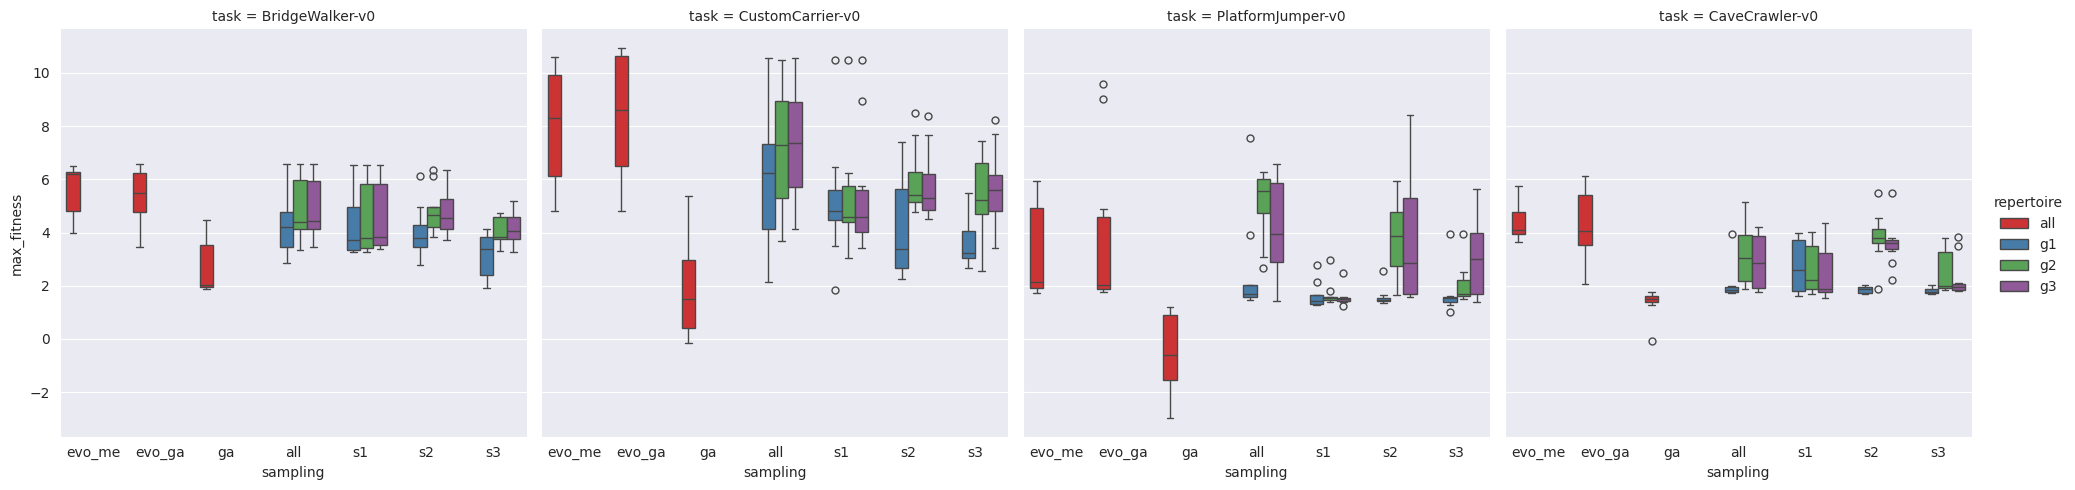

In [11]:
sns.catplot(df,
            x="sampling",
            y="max_fitness",
            col="task",
            col_wrap=4,
            hue="repertoire",
            palette="Set1",
            kind="box",
            )
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

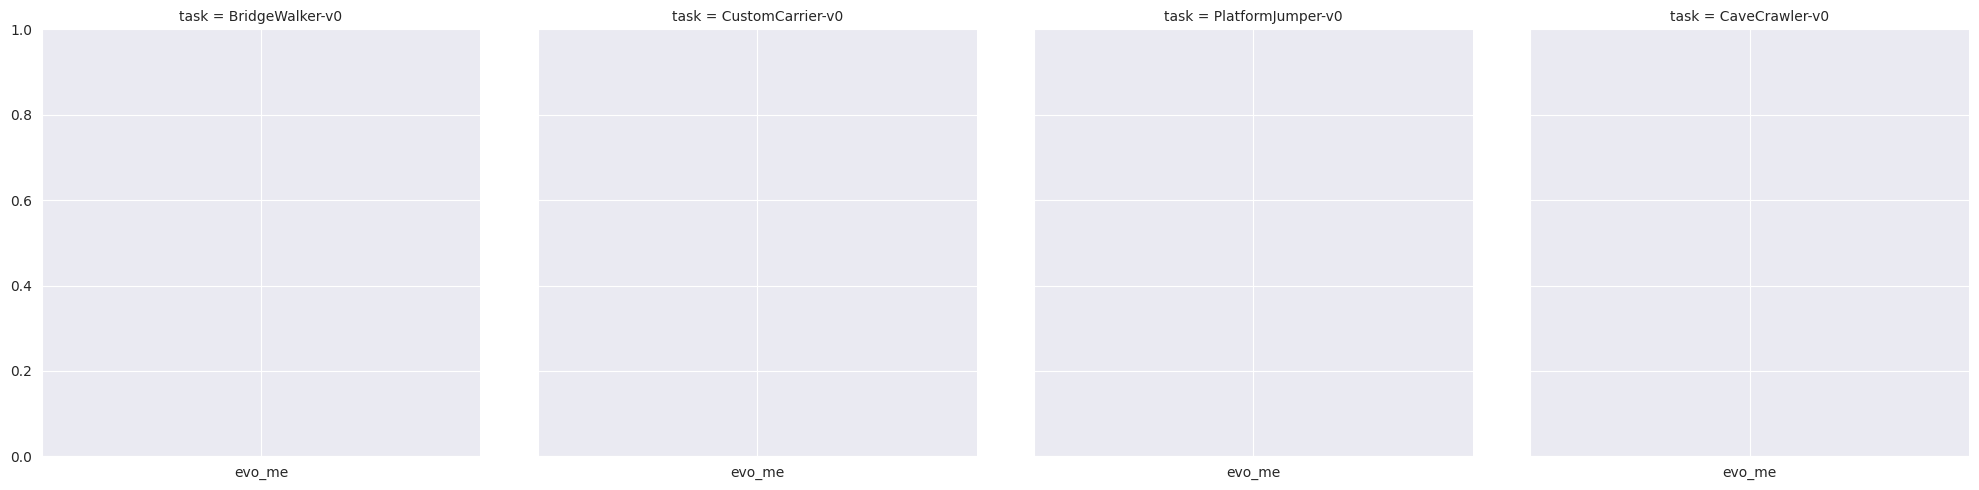

In [12]:
sns.catplot(df,
            x="sampling",
            y="coverage3",
            col="task",
            col_wrap=4,
            hue="repertoire",
            palette="Set1",
            kind="box",
            )
plt.show()

## Bodies observation

In [43]:
from pathlib import Path
import yaml
from bbbqd.body.body_utils import compute_body_mask, compute_body_float_genome_length

seed = 0
dest_rep = "r2"
for task in tasks:
    print(task.replace("-v0", ""), end=" & &")
    for origin_rep_id in range(1, 4):
        origin_rep = f"g{origin_rep_id}"
        folder = f"../results/transfer/evo-body-10x10-floor-{sampling}_{seed}_{origin_rep}_{task}"
        config = yaml.safe_load(Path(f"{folder}/config.yaml").read_text())
        body_encoding_fn = compute_body_encoding_function(config)
        fitnesses = jnp.load(f"{folder}/{dest_rep}_fitnesses.npy")
        genotypes = jnp.load(f"{folder}/{dest_rep}_genotypes.npy")
        best_genotype = genotypes[jnp.argmax(fitnesses)]
        body_mask_length = len(compute_body_mask(config))
        body_float_length = compute_body_float_genome_length(config)
        body_genome, controller_genome = jnp.split(best_genotype, [body_mask_length + body_float_length])
        body = body_encoding_fn(body_genome)
        body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=0)), axis=1)  # remove empty columns
        body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=1)), axis=0)  # remove empty rows
        h, w = body.shape
        body_string = "-".join("".join(map(str, r)) for r in body)
        latex_command = f"\\vsrevogym{{{w}}}{{{h}}}{{{body_string}}}"
        print(latex_command, end=" & ")
    print()

BridgeWalker & &\vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{7}{5}{3120030-1343044-0433001-0001334-0000013} & \vsrevogym{8}{5}{21200300-03440300-03330440-00043330-00000443} & 
CustomCarrier & &\vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443} & \vsrevogym{8}{6}{21200000-03410000-02330230-00013331-00000443-00000400} & 
PlatformJumper & &\vsrevogym{7}{6}{1000000-1312210-0001131-0304400-0232400-0404000} & \vsrevogym{8}{7}{04244110-00004044-00004013-00004000-00004000-00034000-42440000} & \vsrevogym{8}{6}{21200000-23130000-04330400-00043330-00000443-00002400} & 
CaveCrawler & &\vsrevogym{8}{5}{31201000-00111131-30442000-11240000-40400000} & \vsrevogym{10}{6}{2120000000-0342000000-0433040000-0004333000-0000044321-0000000020} & \vsrevogym{8}{5}{21300020-03440040-04330120-00043330-00000433} & 


In [44]:
from pathlib import Path
import yaml
from bbbqd.body.body_utils import compute_body_mask, compute_body_float_genome_length, compute_body_encoding_function

seed = 0
dest_rep = "r2"
for task in ["floor"] + tasks:
    print(task.replace('-v0', ''), end=" ")
    folder = f"../results/me/evo-body-10x10-{task.replace('-v0', '').lower()}-{sampling}_{seed}"
    config = yaml.load(Path(f"{folder}/config.yaml").read_text(), Loader=yaml.FullLoader)
    body_encoding_fn = compute_body_encoding_function(config)
    fitnesses = jnp.load(f"{folder}/{dest_rep}_fitnesses.npy")
    genotypes = jnp.load(f"{folder}/{dest_rep}_genotypes.npy")
    best_genotype = genotypes[jnp.argmax(fitnesses)]
    body_mask_length = len(compute_body_mask(config))
    body_float_length = compute_body_float_genome_length(config)
    body_genome, controller_genome = jnp.split(best_genotype, [body_mask_length + body_float_length])
    body = body_encoding_fn(body_genome)
    body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=0)), axis=1)  # remove empty columns
    body = np.delete(body, np.argwhere(np.all(body[..., :] == 0, axis=1)), axis=0)  # remove empty rows
    h, w = body.shape
    body_string = "-".join("".join(map(str, r)) for r in body)
    latex_command = f"\\vsrevogym{{{w}}}{{{h}}}{{{body_string}}}"
    print(latex_command)

floor \vsrevogym{8}{5}{21210000-03410000-02330430-00013331-00000443}
BridgeWalker \vsrevogym{6}{8}{000400-000420-000400-000433-002040-413140-043320-120000}
CustomCarrier \vsrevogym{8}{7}{00002414-00004310-00004000-33334000-01214000-24000000-04000000}
PlatformJumper \vsrevogym{6}{8}{000100-000140-000410-004043-004430-043400-341400-420000}
CaveCrawler \vsrevogym{8}{7}{10000000-23000000-12000000-04220000-00040000-01334022-00011232}
